**Uploading train and test data**

In [1]:
# Colab library to upload files to notebook
from google.colab import files

uploaded = files.upload()

Saving test_data.txt to test_data.txt
Saving train_data.txt to train_data.txt


**Imports**

In [2]:
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub 

import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
nltk.download('stopwords')


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
vocab_size = 5000
embedding_dim = 64
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

**Text Files to Dataframes**

In [4]:
train_data_name='train_data.txt'
test_data_name='test_data.txt'

In [5]:
def df_maker(file_name):
  df = pd.DataFrame(columns=['sentence','sentiment'])
  f = open(file_name,'r')
  lines = f.readlines()
  f.close()

  sentences=[]
  sentiment=[]
  for line in lines:
    sc=line.split(';')
    st=re.sub('\n', '', sc[1])
    sentences.append(sc[0])
    sentiment.append(st)
  
  df['sentence']=sentences
  df['sentiment']=sentiment

  return df

In [6]:
train_df=df_maker(train_data_name)
test_df=df_maker(test_data_name)

In [7]:
train_df.head()

,sentence,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
test_df.head()

,sentence,sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


**Dataframes to CSV**

In [9]:
train_df.to_csv(r'/content/train.csv')
test_df.to_csv(r'/content/test.csv')

In [10]:
train_df['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

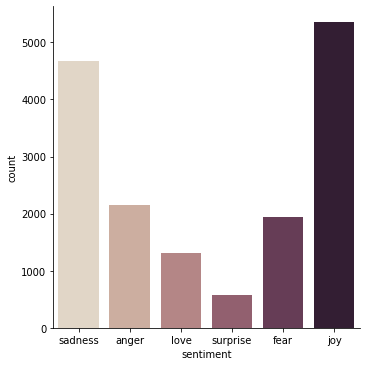

In [11]:
sns.catplot(x="sentiment", kind="count", palette="ch:.25", data=train_df)

In [12]:
X_train=train_df
X_test=test_df

**Imbalanced Dataset so making a class weight class**

In [13]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight('balanced',np.unique(train_df['sentiment']),train_df['sentiment'] ))

In [14]:
class_weights.sort()
print(class_weights)

[0.49732686808404825, 0.5715102157451064, 1.2351397251814111, 1.3766993632765445, 2.044989775051125, 4.662004662004662]


In [15]:
weights={}
for index, weight in enumerate(class_weights):
  weights[index]=weight
print(weights)

{0: 0.49732686808404825, 1: 0.5715102157451064, 2: 1.2351397251814111, 3: 1.3766993632765445, 4: 2.044989775051125, 5: 4.662004662004662}


**Converting into Tensors**

In [16]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train['sentence'].values,X_train['sentiment'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test['sentence'].values,X_test['sentiment'].values))

In [17]:
for text, target in dataset_train.take(5):
  print(text, target)

tf.Tensor(b'i didnt feel humiliated', shape=(), dtype=string) tf.Tensor(b'sadness', shape=(), dtype=string)
tf.Tensor(b'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', shape=(), dtype=string) tf.Tensor(b'sadness', shape=(), dtype=string)
tf.Tensor(b'im grabbing a minute to post i feel greedy wrong', shape=(), dtype=string) tf.Tensor(b'anger', shape=(), dtype=string)
tf.Tensor(b'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', shape=(), dtype=string) tf.Tensor(b'love', shape=(), dtype=string)
tf.Tensor(b'i am feeling grouchy', shape=(), dtype=string) tf.Tensor(b'anger', shape=(), dtype=string)


**sentiment column into tensor numerical representation**

In [18]:
table =tf.lookup.StaticHashTable(
    initializer= tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['joy','sadness' ,'anger','fear','love','surprise']),
        values=tf.constant([0,1,2,3,4,5]),
        ),
        default_value= tf.constant(-1),
        name="target_encoding"
)

@tf.function
def target(x):
  return table.lookup(x)

In [19]:
def show_batch(dataset, size=5):
  for batch,label in dataset.take(size):
    print(batch.numpy())
    print(target(label).numpy())

In [20]:
show_batch(dataset_test,6)

b'im feeling rather rotten so im not very ambitious right now'
1
b'im updating my blog because i feel shitty'
1
b'i never make her separate from me because i don t ever want her to feel like i m ashamed with her'
1
b'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'
0
b'i was feeling a little vain when i did this one'
1
b'i cant walk into a shop anywhere where i do not feel uncomfortable'
3


**One hot encoder value of Sentiments**

In [21]:
def fetch (text,labels):
  return text, tf.one_hot(target(labels),6)

In [22]:
train_data_f = dataset_train.map(fetch)
test_data_f = dataset_test.map(fetch)

In [23]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'i didnt feel humiliated'>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0.], dtype=float32)>)

In [24]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'i didnt feel humiliated',
        b'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
        b'im grabbing a minute to post i feel greedy wrong',
        b'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
        b'i am feeling grouchy'], dtype=object)>,
 <tf.Tensor: shape=(5, 6), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.]], dtype=float32)>)

**Pre-trained embedding from tensorflow hub which is trained on google news dataset**

In [25]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, output_shape =[128],input_shape=[],dtype= tf.string, trainable=True)

hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.03119449,  0.2242772 ,  0.0178397 , -0.00631464,  0.07569598,
        -0.02167997, -0.01995106,  0.0139362 , -0.11697823, -0.21412945,
         0.11037409, -0.07088833,  0.06459473, -0.10667394,  0.02290358,
         0.09635673,  0.08349571, -0.20847768, -0.11839393, -0.09691336,
         0.02987843, -0.0729554 ,  0.07117689, -0.06295152, -0.1439673 ,
        -0.02536686,  0.08038701,  0.05423144, -0.02569952, -0.16882923,
         0.15896752, -0.0673883 , -0.0456707 , -0.0261621 ,  0.07334181,
        -0.06786316, -0.0597977 , -0.12145151,  0.14427376,  0.23829868,
        -0.23179632, -0.09926786, -0.02584722, -0.16371083,  0.02891883,
        -0.05457221,  0.11446702,  0.05844094, -0.04972576, -0.01821013,
        -0.05708738,  0.06195338, -0.17412621,  0.05468813, -0.12120245,
        -0.12841359,  0.02613652,  0.02080501, -0.0983246 , -0.03884013,
        -0.08751262,  0.09685411,  0.13460916, -0.00901618,  0.11266208,
 

**Model(2layers of bidirectional LSTM and 2 Dense Layers)**

In [26]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape( target_shape=(128 , 1 ) ))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))
for units in [128, 64 ]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [27]:
model.compile(optimizer='adam', loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics =['accuracy'])

In [28]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.000001,
#     restore_best_weights=True,
# )

In [29]:
train_data_f= train_data_f.shuffle(3000).batch(512)
test_data_f=test_data_f.batch(512)

In [55]:
history =model.fit(train_data_f,epochs=20,validation_data=test_data_f,verbose=1,class_weight=weights)

Epoch 1/20
32/32 [==============================] - 57s 2s/step - loss: 0.5470 - accuracy: 0.8221 - val_loss: 0.8520 - val_accuracy: 0.7280
Epoch 2/20
32/32 [==============================] - 57s 2s/step - loss: 0.4176 - accuracy: 0.8733 - val_loss: 0.8471 - val_accuracy: 0.7600
Epoch 3/20
32/32 [==============================] - 59s 2s/step - loss: 0.2921 - accuracy: 0.9147 - val_loss: 0.8778 - val_accuracy: 0.7710
Epoch 4/20
32/32 [==============================] - 57s 2s/step - loss: 0.2186 - accuracy: 0.9345 - val_loss: 0.9195 - val_accuracy: 0.7590
Epoch 5/20
32/32 [==============================] - 59s 2s/step - loss: 0.1734 - accuracy: 0.9469 - val_loss: 0.9709 - val_accuracy: 0.7665
Epoch 6/20
32/32 [==============================] - 57s 2s/step - loss: 0.1476 - accuracy: 0.9588 - val_loss: 1.0174 - val_accuracy: 0.7660
Epoch 7/20
32/32 [==============================] - 57s 2s/step - loss: 0.1293 - accuracy: 0.9631 - val_loss: 1.0287 - val_accuracy: 0.7610
Epoch 8/20
32/32 [==

**Model accuracy vs Epochs Graphs**

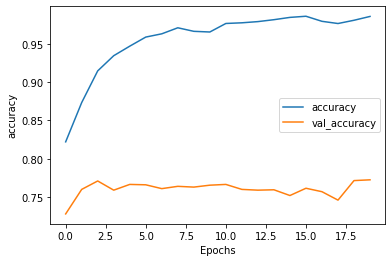

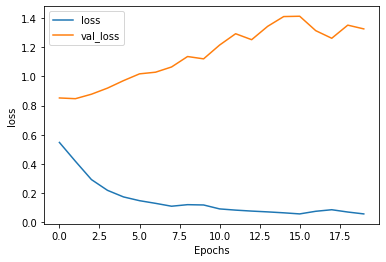

In [56]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [57]:
test_data,test_labels= next(iter(dataset_test.map(fetch).batch(2000)))
y_pred =model.predict(test_data)

**['joy','sadness' ,'anger','fear','love','surprise']) ->[0,1,2,3,4,5]**
**Classification Report**

In [58]:
from sklearn.metrics import classification_report
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       695
           1       0.87      0.78      0.82       581
           2       0.76      0.81      0.78       275
           3       0.55      0.67      0.60       224
           4       0.58      0.68      0.62       159
           5       0.55      0.74      0.63        66

    accuracy                           0.77      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.79      0.77      0.78      2000



**Model is 77% accurate**

**Confusion Matrix**

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1))

array([[562,  12,   6,  46,  54,  15],
       [ 16, 453,  44,  43,  24,   1],
       [  5,  19, 222,  24,   0,   5],
       [ 14,  21,  18, 151,   1,  19],
       [ 36,  12,   2,   1, 108,   0],
       [  3,   1,   2,  11,   0,  49]])

**Initial Approach (Commented the code )**

**Text Preprocessing**

*  Remove numbers
*   Stemming
*   Part of speech tagging
*   Remove punctuation
*   Lowercase
*   Remove stopwords

In [35]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

# def clean_text(text):
#     """
#         text: a string
        
#         return: modified initial string
#     """
#     text = text.lower() # lowercase text
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = text.replace('x', '')
# #    text = re.sub(r'\W+', '', text)
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
#     return text

In [36]:
# train_df['cleaned_text'] = train_df['sentence'].apply(clean_text)
# train_df.head()

In [37]:
# train_size = int(len(train_df) * training_portion)

# train_articles = train_df['cleaned_text'][0: train_size]
# train_labels = train_df['sentiment'][0: train_size]

# validation_articles = train_df['cleaned_text'][train_size:]
# validation_labels = train_df['sentiment'][train_size:]

# print(train_size)
# print(len(train_articles))
# print(len(train_labels))
# print(len(validation_articles))
# print(len(validation_labels))

In [38]:
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(train_articles)
# word_index = tokenizer.word_index
# dict(list(word_index.items())[0:10])

In [39]:
# train_sequences = tokenizer.texts_to_sequences(train_articles)
# print(train_sequences[10])

In [40]:
# train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# print(len(train_sequences[0]))
# print(len(train_padded[0]))

# print(len(train_sequences[1]))
# print(len(train_padded[1]))

# print(len(train_sequences[10]))
# print(len(train_padded[10]))

In [41]:
# validation_sequences = tokenizer.texts_to_sequences(validation_articles)
# validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# print(len(validation_sequences))
# print(validation_padded.shape)

In [42]:
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(train_df['sentiment'])

# training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
# validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
# print(training_label_seq[0])
# print(training_label_seq[1])
# print(training_label_seq[2])
# print(training_label_seq.shape)

# print(validation_label_seq[0])
# print(validation_label_seq[1])
# print(validation_label_seq[2])
# print(validation_label_seq.shape)

In [43]:
# label_word_index = label_tokenizer.word_index
# dict(list(label_word_index.items()))

In [44]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_article(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])
# print(decode_article(train_padded[10]))
# print('---')
# print(train_articles[10])

**Model**

In [45]:
# model = tf.keras.Sequential([
#     # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
# #    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     # use ReLU in place of tanh function since they are very good alternatives of each other.
#     tf.keras.layers.Dense(embedding_dim, activation='relu'),
#     # Add a Dense layer with 7 units and softmax activation.
#     # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
#     tf.keras.layers.Dense(7, activation='softmax')
# ])
# model.summary()

In [46]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# num_epochs =5
# history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

In [47]:
# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.legend([string, 'val_'+string])
#   plt.show()
  
# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

In [48]:
# txt = ['im feeling rather rotten so im not very ambitious right now']
# seq = tokenizer.texts_to_sequences(txt)
# padded = pad_sequences(seq, maxlen=max_length)
# pred = model.predict(padded)
# labels = ['joy', 'sadness', 'anger', 'fear', 'love','surprise']
# print(pred, labels[np.argmax(pred)])

In [49]:
# test_df['cleaned_text'] = test_df['sentence'].apply(clean_text)
# test_df.head()

In [50]:
# test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
# test_padded = pad_sequences(test_sequences, maxlen=max_length)
# test_pred =model.predict(test_padded)
# test_df['predicted']=[labels[np.argmax(i)] for i in test_pred]

In [51]:
# from sklearn.metrics import accuracy_score
# print(accuracy_score(test_df['sentiment'],test_df['predicted']))

In [52]:
# test_df.head()

In [53]:
# pd.crosstab(test_df['sentiment'],test_df['predicted'])